http://artelab.dista.uninsubria.it/res/research/papers/2019/2019-IVCNZ-Nawaz-Birds.pdf

https://github.com/nicolalandro/ntsnet-cub200/blob/master/nts_net/model.py

In [31]:
# Standard library imports
import copy
from datetime import datetime
import os
import random
import time

# Third party imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F 
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score

# Local application imports
from helper_functions import *

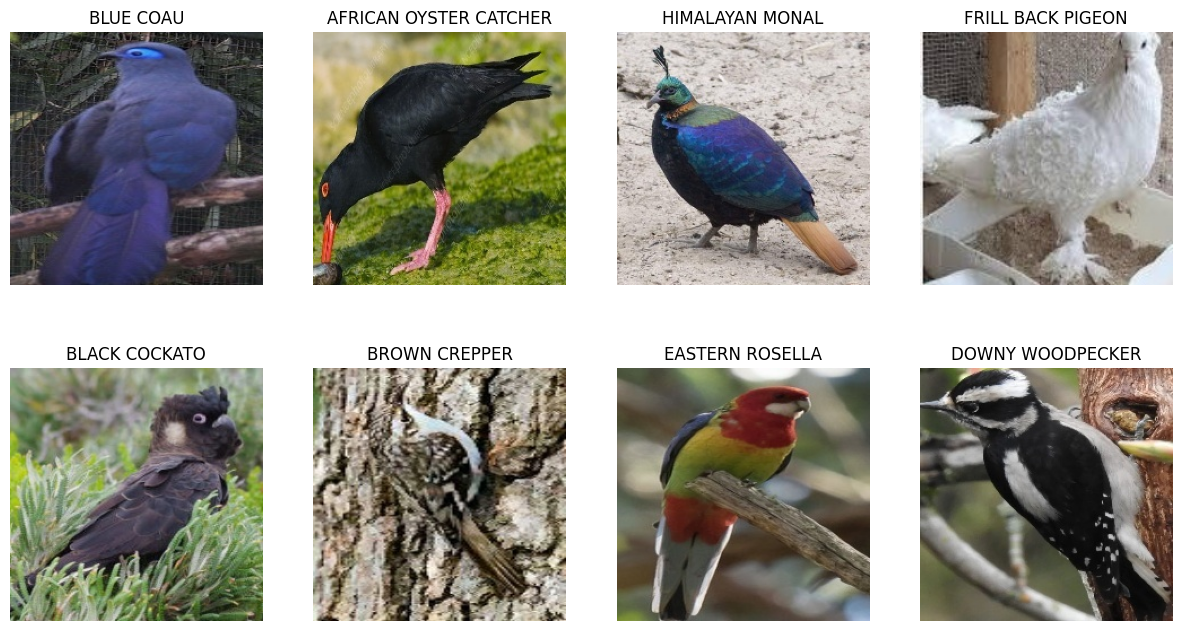

In [3]:
show_random_birbs(img_dir="bird-525/train")

In [7]:
get_height_width(path="bird-525\\train\\RED BROWED FINCH\\001.jpg")

The image size is 224 x 224


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
num_classes = 0
for root, dirs, files in os.walk("birds-525\\train-subset"):
    num_classes += len(dirs)

print(f"There are {num_classes} types of brids in the train dataset.")

There are 0 types of brids in the train dataset.


In [12]:
# Define a transform to convert the data to PyTorch Tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize all images to 224x224
    transforms.ToTensor()
])

# Load the training data
train_data = datasets.ImageFolder(
    root="birds-525\\train-subset",
    transform=transform
)

val_data = datasets.ImageFolder(
    root="birds-525\\valid-subset",
    transform=transform
)


# Create a data loader
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=32, 
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_data, 
    batch_size=32,
    shuffle=False
)

In [13]:
class BirbNet(nn.Module):
    def __init__(self, num_classes):
        super(BirbNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [16]:
model = BirbNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.2)

epochs = 3
patience = 2

model, loss_history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, epochs, patience)

Step [10/39] | Loss: 1.6880232095718384 | Accuracy: 0.275
Step [20/39] | Loss: 1.279490351676941 | Accuracy: 0.4
Step [30/39] | Loss: 1.0429965257644653 | Accuracy: 0.5114583333333333
Epoch [1/3], Loss: 54.21716332435608, Accuracy: 0.5819209039548022, Validation Loss: 0.7173920571804047, Validation Accuracy: 0.875
Step [10/39] | Loss: 0.6950365900993347 | Accuracy: 0.88125
Step [20/39] | Loss: 0.5212661027908325 | Accuracy: 0.890625
Step [30/39] | Loss: 0.3564453125 | Accuracy: 0.9083333333333333
Epoch [2/3], Loss: 22.50523841381073, Accuracy: 0.9128329297820823, Validation Loss: 0.3561103641986847, Validation Accuracy: 0.925
Step [10/39] | Loss: 0.3727092742919922 | Accuracy: 0.940625
Step [20/39] | Loss: 0.4536702334880829 | Accuracy: 0.9390625
Step [30/39] | Loss: 0.3316865861415863 | Accuracy: 0.9385416666666667
Epoch [3/3], Loss: 14.819695770740509, Accuracy: 0.9322033898305084, Validation Loss: 0.2707165628671646, Validation Accuracy: 0.9


In [17]:
save_model(model, "./models/birbnet.pt")

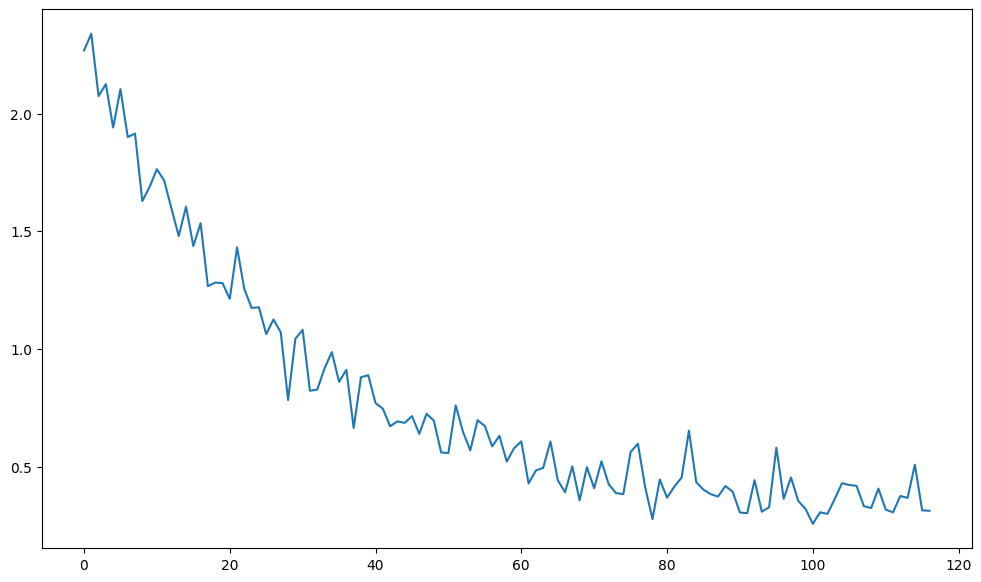

In [18]:
plot_loss(loss_history, save=False)

## Classify new data

In [19]:
def predict_image(model, image_path, show_image=False):
    # Ensure the model is in evaluation mode
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path)
    input_image = transform(image)
    input_image = input_image.unsqueeze(0)
    input_image = input_image.to(device)

    # Make the prediction
    with torch.no_grad():
        output = model(input_image)
        _, predicted_class = torch.max(output, 1)

    # Map the predicted class index to the corresponding class label
    predicted_class_label = train_data.classes[predicted_class.item()]

    if show_image:# Display the image and the prediction
        plt.imshow(image)
        plt.title(f'Predicted class: {train_data.classes[predicted_class.item()]}')
        plt.axis(False)
        plt.show()

    return predicted_class_label

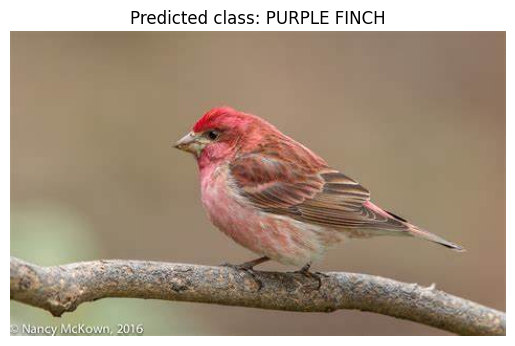

'PURPLE FINCH'

In [24]:
predict_image(model, "birb-images/purple-finch.jpg", show_image=True)

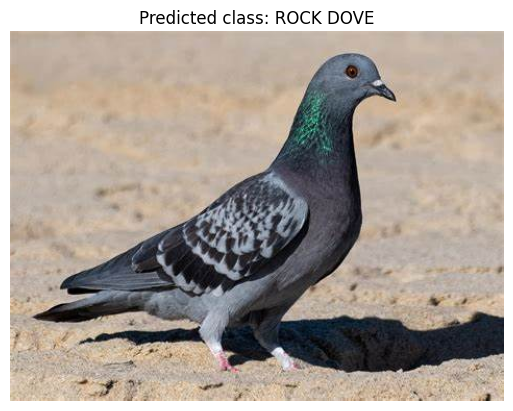

'ROCK DOVE'

In [22]:
predict_image(model, "birb-images/rock-dove.jpg", show_image=True)

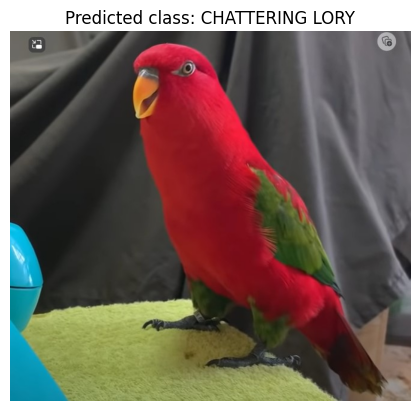

'CHATTERING LORY'

In [23]:
predict_image(model, "birb-images/red-birb.jpg", show_image=True)

## Object detection on CUB 200-2011

Maybe try this:
- https://discuss.pytorch.org/t/how-to-load-cub-200-2011-in-pytorch/97784/2
- https://github.com/ChikinH/DeepLearning/blob/main/CUB_200_2011_CNN_YOLO.ipynb
- https://colab.research.google.com/drive/1KzGRSNQpP4BonRKj3ZwGMTGdi-e2y8z-?authuser=1#scrollTo=Bj_riya9wjJI
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
- https://github.com/Yangqing/iceberk/blob/master/visiondata/_cub.py

In [1]:
import torch 
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

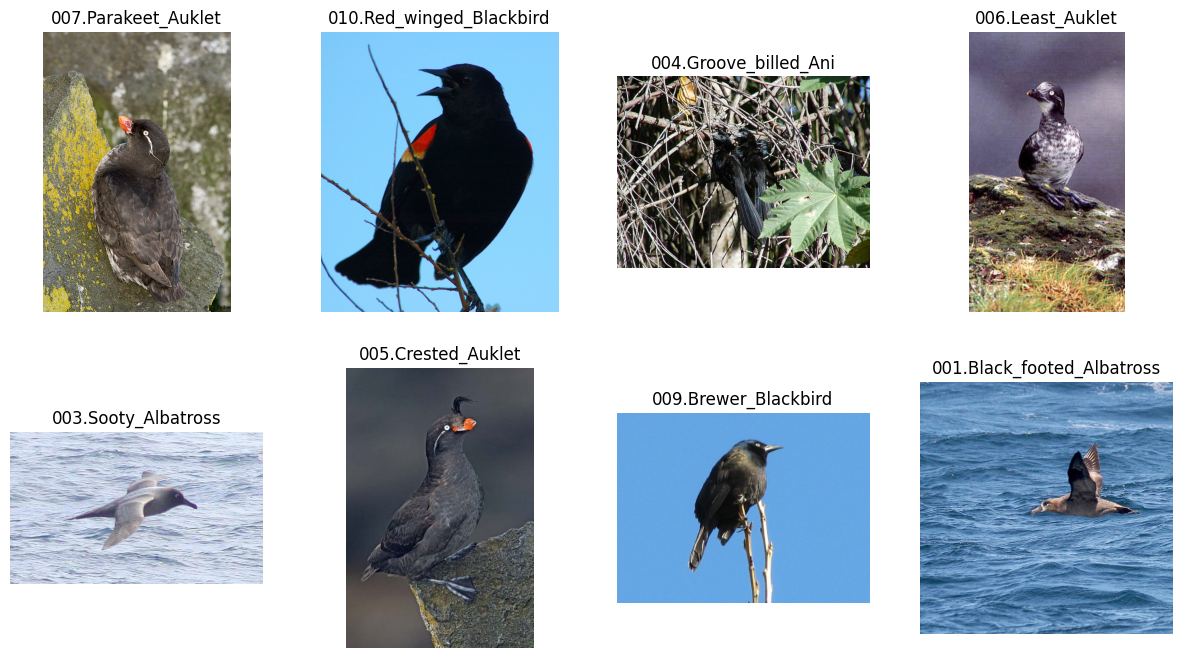

In [6]:
show_random_birbs(img_dir="./cub-200-2011-subset/images")

In [ ]:
get_height_width(path="./cub-200-2011/images/035.Purple_Finch/Purple_Finch_0001_27571.jpg")

In [2]:
import pandas as pd

# Load the class labels
class_labels = pd.read_csv("cub-200-2011/image_class_labels.txt", sep=" ", header=None)
class_labels.columns = ["Image", "Label"]

# Load the bounding boxes
bounding_boxes = pd.read_csv("cub-200-2011/bounding_boxes.txt", sep=" ", header=None)
bounding_boxes.columns = ["Image", "x", "y", "width", "height"]

# Merge the two dataframes on the Image column
data = pd.merge(class_labels, bounding_boxes, on='Image')

In [3]:
# Create a list of ones with the same length as your data
objectness_labels = [1] * len(data)

# Convert the list to a pandas Series
objectness_labels = pd.Series(objectness_labels, name="Objectness")

# Add the objectness labels to your data
data = pd.concat([data, objectness_labels], axis=1)

In [4]:
data

,Image,Label,x,y,width,height,Objectness
0,1,1,60.0,27.0,325.0,304.0,1
1,2,1,139.0,30.0,153.0,264.0,1
2,3,1,14.0,112.0,388.0,186.0,1
3,4,1,112.0,90.0,255.0,242.0,1
4,5,1,70.0,50.0,134.0,303.0,1
...,...,...,...,...,...,...,...
11783,11784,200,89.0,95.0,354.0,250.0,1
11784,11785,200,157.0,62.0,184.0,219.0,1
11785,11786,200,190.0,102.0,198.0,202.0,1
11786,11787,200,3.0,20.0,408.0,307.0,1


In [5]:
import torch 
import torch.nn as nn

from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor

class BirdDataset(ImageFolder):
    def __init__(self, root, data, objectness_labels, transform=None):
        super().__init__(root, transform=transform)
        self.data = data
        self.objectness_labels = objectness_labels

    def __getitem__(self, index):
        # Get the image and label like usual
        img, label = super().__getitem__(index)

        # Get the image name from the file path
        image_name = self.imgs[index][0].split('/')[-1].split('.')[0]

        # Extract only the number from the image name
        image_number = ''.join(filter(str.isdigit, image_name))

        # Get the bounding box for this image
        bbox = self.data[self.data['Image'] == int(image_number)][['x', 'y', 'width', 'height']].values[0]

        # Get the objectness label for this image
        objectness_label = self.objectness_labels[int(image_number)]

        return img, label, bbox, objectness_label

C:\Users\leopu\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the dataset
dataset = BirdDataset("cub-200-2011/images", data, objectness_labels=objectness_labels, transform=transform)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
import torch
import torch.nn as nn
from torchvision import models

class BirdNetOD(nn.Module):
    def __init__(self, num_classes):
        super(BirdNetOD, self).__init__()

        # Load the pretrained ResNet model
        self.resnet = models.resnet18(pretrained=True)

        # Number of features in the last layer of ResNet
        num_features = self.resnet.fc.in_features

        # Remove the last layer (fully connected layer) of ResNet
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

        # Add a new fully connected layer for class scores and bounding box coordinates
        self.fc = nn.Linear(num_features, num_classes * 5)

        # Store the number of classes
        self.num_classes = num_classes

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        # Split the output into class scores and bounding box coordinates
        class_scores = x[:, :self.num_classes]
        bbox_coords = x[:, self.num_classes:-self.num_classes].view(-1, (x.size(1) - 2*self.num_classes) // 4, 4)

        # The remaining elements are the objectness scores
        objectness_scores = x[:, -self.num_classes:]

        return class_scores, objectness_scores, bbox_coords


In [8]:
class YOLOLoss(nn.Module):
    def __init__(self):
        super(YOLOLoss, self).__init__()

    def forward(self, class_scores, objectness_scores, bbox_coords, class_labels, objectness_labels, bboxes):
        # Compute the classification loss
        class_loss = F.cross_entropy(class_scores, class_labels)

        # Compute the objectness loss
        objectness_scores = objectness_scores.reshape(-1, 1)
        objectness_labels = objectness_labels.view(-1, 1).repeat(1, 200).view(-1, 1).float()
        objectness_loss = F.mse_loss(objectness_scores, objectness_labels)

        # Compute the localization loss
        localization_loss = 0
        for i in range(bbox_coords.shape[1]):
            pred_centers = bbox_coords[:, i, :2]
            pred_sizes = torch.sqrt(torch.abs(bbox_coords[:, i, 2:]))
            gt_centers = bboxes[:, :2]
            gt_sizes = torch.sqrt(bboxes[:, 2:])

            # print(f"pred_centers: {pred_centers}")
            # print(f"pred_sizes: {pred_sizes}")
            # print(f"pred_centers: {gt_centers}")
            # print(f"gt_sizes: {gt_sizes}")
            localization_loss += F.mse_loss(pred_centers, gt_centers) + F.mse_loss(pred_sizes, gt_sizes)
        localization_loss /= bbox_coords.shape[1]

        # Sum up the losses
        loss = class_loss + objectness_loss + localization_loss

        return loss

In [9]:
from torchinfo import summary 

model_od = BirdNetOD(num_classes=200).to(device)
# print(summary(model_od))

C:\Users\leopu\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\leopu\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
torch.autograd.set_detect_anomaly(True)

In [15]:
# Define the loss function
criterion = YOLOLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model_od.parameters(), lr=0.001)

# Number of epochs
epochs = 3

loss_history = []
# Start the training loop
for epoch in range(epochs):
    for i, (images, labels, bboxes, objectness_labels) in enumerate(dataloader):  # Load objectness_labels from your dataloader
        # Move the data to the GPU if available
        images = images.to(device)
        labels = labels.long().to(device)
        bboxes = bboxes.float().to(device)
        objectness_labels = objectness_labels.long().to(device)  # Move objectness_labels to the device

        # print(f"Images shape: {images.shape}")
        # print(f"bboxes shape: {bboxes.shape}")
        # print(f"objectness_labels shape: {objectness_labels.shape}")
        # print(f"labels shape: {labels.shape}")

        # Forward pass
        class_scores, objectness_scores, bbox_coords = model_od(images)

        class_scores = class_scores.float()
        objectness_scores = objectness_scores.float()
        bbox_coords = bbox_coords.float()

        # print(f"class_scores shape: {class_scores.shape}")
        # print(f"objectness_scores shape: {objectness_scores.shape}")
        # print(f"bbox_coords shape: {bbox_coords.shape}")

        # Compute the loss
        loss = criterion(class_scores, objectness_scores, bbox_coords, labels, objectness_labels, bboxes)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        for name, param in model_od.named_parameters():
            if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
                print(f"Warning: NaN or inf found in gradient of {name}")

        optimizer.step()

        # Print progress
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}')
            loss_history.append(loss.item())

    print(f'Epoch [{epoch+1}/{epochs}] Completed, Avg Loss: {loss.item()}')

Epoch [1/3], Step [10/369], Loss: 7905.2529296875
Epoch [1/3], Step [20/369], Loss: 5063.3369140625
Epoch [1/3], Step [30/369], Loss: 4545.41259765625
Epoch [1/3], Step [40/369], Loss: 3054.48876953125
Epoch [1/3], Step [50/369], Loss: 4331.96630859375
Epoch [1/3], Step [60/369], Loss: 3629.811767578125
Epoch [1/3], Step [70/369], Loss: 2353.02685546875
Epoch [1/3], Step [80/369], Loss: 3016.623779296875
Epoch [1/3], Step [90/369], Loss: 2745.172119140625
Epoch [1/3], Step [100/369], Loss: 1982.3055419921875
Epoch [1/3], Step [110/369], Loss: 2911.623291015625
Epoch [1/3], Step [120/369], Loss: 3893.6201171875
Epoch [1/3], Step [130/369], Loss: 2369.41650390625
Epoch [1/3], Step [140/369], Loss: 2925.06396484375
Epoch [1/3], Step [150/369], Loss: 2900.744384765625
Epoch [1/3], Step [160/369], Loss: 2635.30859375
Epoch [1/3], Step [170/369], Loss: 2631.938232421875
Epoch [1/3], Step [180/369], Loss: 2779.51318359375
Epoch [1/3], Step [190/369], Loss: 2366.127685546875
Epoch [1/3], Step 

In [16]:
torch.save(model_od.state_dict(), "./models/birbnet18-od-weights.pt")

In [41]:
import matplotlib.patches as patches

import matplotlib.patches as patches

def draw_boxes(image, bbox_coords):
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Draw bounding box
    box = bbox_coords.squeeze(0)
    # Create a Rectangle patch
    rect = patches.Rectangle((box[0].item(), box[1].item()), box[2].item() - box[0].item(), box[3].item() - box[1].item(), linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

In [54]:
def predict_od_image(model, image_path, show_image=False):
    # Ensure the model is in evaluation mode
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path)
    orig_width, orig_height = image.size
    input_image = transform(image)
    input_image = input_image.unsqueeze(0)
    input_image = input_image.to(device)

    # Make the prediction
    with torch.no_grad():
        class_scores, objectness_scores, bbox_coords = model(input_image)
        print(class_scores)
        print(objectness_scores)
        print(bbox_coords)

        print(f"class_scores {class_scores.shape}")
        print(f"objectness_scores bbox_coords {objectness_scores.shape}")
        print(f"bbox_coords shape {bbox_coords.shape}")
        _, predicted_class = torch.max(class_scores, 1)  # Use class_scores instead of output

    # Map the predicted class index to the corresponding class label
    predicted_class_label = dataset.classes[predicted_class.item()]

    if show_image:  # Display the image and the prediction
        # Get the bounding box with the highest objectness score
        max_score_index = torch.argmax(objectness_scores)
        best_bbox = bbox_coords[0, max_score_index]

        # Scale the bounding box coordinates back to the original image size
        best_bbox = best_bbox * torch.tensor([orig_width, orig_height, orig_width, orig_height]).to(device)

        # Draw the bounding box on the image
        draw_boxes(image, best_bbox.unsqueeze(0).cpu())  # Make sure to move bbox_coords to cpu
        plt.title(f'Predicted class: {dataset.classes[predicted_class.item()]}')
        plt.axis(False)
        plt.show()

    return predicted_class_label



tensor([[ -9.4698,  -9.7328,  -8.8594,  -7.9457,  -8.8380, -11.8145,  -7.6216,
         -11.3893,  -8.6515, -11.5880,  -8.6772,  -7.3482, -10.0536,  -8.7552,
          -9.0389,  -7.8296,  -9.7637, -10.3971,  -8.7198,  -8.5190, -10.1215,
         -10.2321, -10.5739,  -9.2474,  -9.8629,  -9.8265, -10.1805,  -9.7319,
          -8.8395,  -9.4455, -11.6881, -11.5930,  -9.4236,  -8.8122,  -9.0187,
          -9.1686,  -8.9110,  -9.2944,  -8.8276,  -8.4061,  -9.6322,  -8.5322,
         -11.6429, -12.5122,  -9.5542, -10.6224,  -9.6435,  -9.8039,  -9.5368,
         -10.2387, -11.9931, -10.0003,  -9.0887, -10.2555, -11.6507, -10.3572,
         -10.0711,  -9.1267, -10.8362,  -7.9969,  -9.9481, -10.0648,  -8.3009,
          -9.9755,  -8.3645,  -9.1326, -10.1248,  -8.8244,  -9.5413, -10.2443,
         -11.1649, -10.7835, -11.1061, -11.8279, -10.7137,  -9.6672,  -9.8228,
          -9.5863, -10.0611, -10.1985,  -9.7239,  -9.7872,  -9.1291,  -9.7648,
         -10.5678, -10.6452,  -9.5439, -13.8203, -10

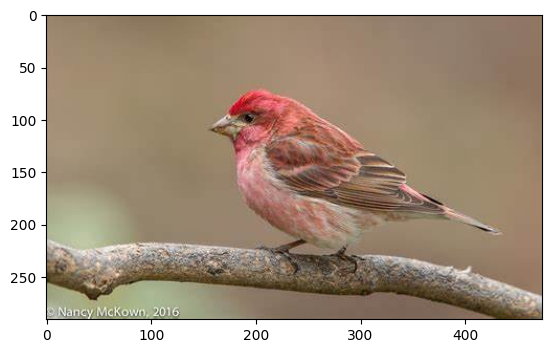

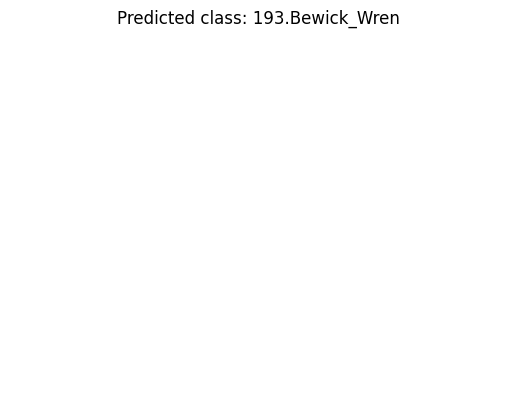

'193.Bewick_Wren'

In [55]:
predict_od_image(model_od, "birb-images/purple-finch.jpg", show_image=True)